In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import io
from google.colab import files
datapath = '/content/drive/My Drive/Ph. D. Coursework/ECEN743_ReinforcementLearning/ECEN743_Project/Models/'

In [13]:
############################ Buffer ############################
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import load_model

#Dimension of State Space for single agent
dim_agent_state = 5
#Number of Agents
num_agents = 3
#Dimension of State Space
dim_state = dim_agent_state*num_agents
# Learning rate for actor-critic models
critic_lr = 1e-4
actor_lr = 5e-5
# Creating Optimizer for actor and critic networks
critic_optimizer = tf.keras.optimizers.legacy.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.legacy.Adam(actor_lr) #from tensorflow.keras.optimizers.legacy
# Discount factor for future rewards
gamma = 0.95
# Used to update target networks
tau = 0.005

class Buffer:
    def __init__(self, buffer_capacity=10000, batch_size=64):
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size
        # Its tells us num of times record() was called.
        self.buffer_counter = 0
        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, dim_state))
        self.action_buffer = np.zeros((self.buffer_capacity, num_agents))
        self.reward_buffer = np.zeros((self.buffer_capacity, num_agents))
        self.next_state_buffer = np.zeros((self.buffer_capacity, dim_state))

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity
        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.buffer_counter += 1

    # We compute the loss and update parameters
    def learn(self, ac_models, cr_models, target_ac, target_cr):
    
      # Updating networks of all the agents
      # by looping over number of agent
        for i in range(num_agents):
            # Get sampling range
            record_range = min(self.buffer_counter, self.buffer_capacity)
            # Randomly sample indices
            batch_indices = np.random.choice(record_range, self.batch_size)
            # Convert to tensors
            state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
            action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
            reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
            reward_batch = tf.cast(reward_batch, dtype=tf.float32)
            next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
            # Training  and Updating ***critic model*** of ith agent
            target_actions = np.zeros((self.batch_size, num_agents))
            for j in range(num_agents):
                target_actions[:,j] = tf.reshape(
                target_ac[j](next_state_batch[:,5*j:5*(j+1)]), [self.batch_size]
                )

            target_action_batch1 = target_actions[:,0]
            target_action_batch2 = target_actions[:,1]
            target_action_batch3 = target_actions[:,2]
            action_batch1 = action_batch[:,0]
            action_batch2 = action_batch[:,1]
            action_batch3 = action_batch[:,2]
    
        # Finding Gradient of loss function
            with tf.GradientTape() as tape:
                y = reward_batch[:,i] + gamma * target_cr[i]([
                                                          next_state_batch, target_action_batch1, 
                                                          target_action_batch2, target_action_batch3
                                                          ])
            
                critic_value = cr_models[i]([
                                         state_batch, action_batch1, action_batch2, action_batch3
                                         ])
            
                critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

            critic_grad = tape.gradient(critic_loss, cr_models[i].trainable_variables)
        
        # Applying gradients to update critic network of ith agent
            critic_optimizer.apply_gradients(
            zip(critic_grad, cr_models[i].trainable_variables)
            )
        # Updating and training of ***critic network*** ended

        # Updating and Training of ***actor network** for ith agent
            actions = np.zeros((self.batch_size, num_agents))
            for j in range(num_agents):
                a = ac_models[j](state_batch[:,5*j:5*(j+1)])
                actions[:,j] = tf.reshape(a, [self.batch_size])

        # Finding gradient of actor model if it is 1st agent
            if i == 0:
                with tf.GradientTape(persistent=True) as tape:
                    action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][0]]))
                    critic_value = cr_models[i]([np.array([state_batch[0]]), action_, np.array([actions[:,1][0]]),
                                           np.array([actions[:,2][0]])])
                critic_grad = tape.gradient(critic_value, action_)
                actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)
                new_actor_grad = [critic_grad[0][0]*element for element in actor_grad]

                for k in range(1,self.batch_size):
                    with tf.GradientTape(persistent=True) as tape:
                        action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][k]]))  
                        critic_value = cr_models[i]([np.array([state_batch[k]]), action_, np.array([actions[:,1][k]]),
                                               np.array([actions[:,2][k]])])
                    critic_grad = tape.gradient(critic_value, action_)
                    actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)
                    for l in range(len(new_actor_grad)):
                        new_actor_grad[l] = new_actor_grad[l] + critic_grad[0][0]*actor_grad[l]

                # Updating gradient network if it is 1st agent
                new_actor_grad = [-1*element/self.batch_size for element in new_actor_grad]
                actor_optimizer.apply_gradients(zip(new_actor_grad, ac_models[i].trainable_variables))
        
            # Finding gradient of actor model if it is 2nd agent
            elif i == 1:
                with tf.GradientTape(persistent=True) as tape:
                    action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][0]]))
                    critic_value = cr_models[i]([np.array([state_batch[0]]), np.array([actions[:,0][0]]),action_,
                                           np.array([actions[:,2][0]])])
                critic_grad = tape.gradient(critic_value, action_)
                actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)
                new_actor_grad = [critic_grad[0][0]*element for element in actor_grad]

                for k in range(1,self.batch_size):
                    with tf.GradientTape(persistent=True) as tape:
                        action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][k]]))
                        critic_value = cr_models[i]([np.array([state_batch[k]]), np.array([actions[:,0][k]]),action_,
                                               np.array([actions[:,2][k]])])
                    critic_grad = tape.gradient(critic_value, action_)
                    actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)
                    for l in range(len(new_actor_grad)):
                        new_actor_grad[l] = new_actor_grad[l] + critic_grad[0][0]*actor_grad[l]

                # Updating gradient network if it is 2nd agent
                new_actor_grad = [-1*element/self.batch_size for element in new_actor_grad]
                actor_optimizer.apply_gradients(zip(new_actor_grad, ac_models[i].trainable_variables))

        # Finding gradient of actor model if it is 3rd agent
        else:
            with tf.GradientTape(persistent=True) as tape:
                action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][0]]))
                critic_value = cr_models[i]([np.array([state_batch[0]]), np.array([actions[:,0][0]]),
                                           np.array([actions[:,1][0]]), action_])
            critic_grad = tape.gradient(critic_value, action_)
            actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)
            new_actor_grad = [critic_grad[0][0]*element for element in actor_grad]

            for k in range(1,self.batch_size):
                with tf.GradientTape(persistent=True) as tape:
                    action_ = ac_models[i](np.array([state_batch[:,5*i:5*(i+1)][k]]))
                    critic_value = cr_models[i]([np.array([state_batch[k]]), np.array([actions[:,0][k]]),
                                               np.array([actions[:,1][k]]), action_])
                critic_grad = tape.gradient(critic_value, action_)
                actor_grad = tape.gradient(action_, ac_models[i].trainable_variables)
                for l in range(len(new_actor_grad)):
                    new_actor_grad[l] = new_actor_grad[l] + critic_grad[0][0]*actor_grad[l]

            # Updating gradient network if it is 3rd agent
            new_actor_grad = [-1*element/self.batch_size for element in new_actor_grad]
            actor_optimizer.apply_gradients(zip(new_actor_grad, ac_models[i].trainable_variables))

# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau, ac_models, cr_models, target_ac, target_cr):
    for i in range(num_agents):
        new_weights = []
        target_variables = target_cr[i].weights
        for j, variable in enumerate(cr_models[i].weights):
            new_weights.append(variable * tau + target_variables[j] * (1 - tau))
        target_cr[i].set_weights(new_weights)
        new_weights = []
        target_variables = target_ac[i].weights
        for j, variable in enumerate(ac_models[i].weights):
            new_weights.append(variable * tau + target_variables[j] * (1 - tau))
        target_ac[i].set_weights(new_weights)

In [4]:
############################ Model ############################
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import load_model

def get_actor():
    # Initialize weights between -3e-5 and 3-e5
    last_init = tf.random_uniform_initializer(minval=-0.00003, maxval=0.00003)
    # Actor will get observation of the agent
    # not the observation of other agents
    inputs = layers.Input(shape=(5,))
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(inputs)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(256, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    # Using tanh activation as action values for
    # for our environment lies between -1 to +1
    outputs = layers.Dense(1, activation="tanh", kernel_initializer=last_init)(out)
    outputs = outputs 
    model = tf.keras.Model(inputs, outputs)
    return model

def get_critic(dim_state):
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)
    # State as input, here this state is
    # observation of all the agents
    # hence this state will have information
    # of observation of all the agents
    state_input = layers.Input(shape=(dim_state))
    state_out = layers.Dense(16, activation="selu", kernel_initializer="lecun_normal")(state_input)
    state_out = layers.BatchNormalization()(state_out)
    state_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(state_out)
    state_out = layers.BatchNormalization()(state_out)
    # Action all the agents as input
    action_input1 = layers.Input(shape=(1))
    action_input2 = layers.Input(shape=(1))
    action_input3 = layers.Input(shape=(1))
    action_input = layers.Concatenate()([action_input1, action_input2, action_input3])
    action_out = layers.Dense(32, activation="selu", kernel_initializer="lecun_normal")(action_input)
    action_out = layers.BatchNormalization()(action_out)
    # Both are passed through seperate layer before concatenating
    concat = layers.Concatenate()([state_out, action_out])
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(concat)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(512, activation="selu", kernel_initializer="lecun_normal")(out)
    out = layers.Dropout(rate=0.5)(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)
    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input1, action_input2, action_input3], outputs)
    return model

In [5]:
############################ Noise ############################
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import load_model

class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=0.4, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)

In [10]:
############################ Environment ############################
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
import random

#Dimension of State Space for single agent
dim_agent_state = 5
#Time Difference Between 2 Steps
dt = 0.4
#Number of Episodes
num_episodes = 3000
#Number of Steps
num_steps = 100
#Minimum turing radius of Pursuer and Evader
rho = 0.3
rho_e = 0.3
#velocity of pursuer
v = 1.0
#Velocity of Evader during training
ve = 0.5
#angle between initial velocity and reference
te = 3*np.pi/4
# Number of agents
num_agents = 3
#Dimension of State Space
dim_state = dim_agent_state*num_agents

class environment:
    def __init__(self):
        self.p1_rx = random.uniform(0.0, 5.0)
        self.p1_ry = random.uniform(0.0, 5.0)
        self.p2_rx = random.uniform(0.0, 5.0)
        self.p2_ry = random.uniform(0.0, 5.0)
        self.p1_vx = v
        self.p1_vy = 0.0
        self.p2_vx = v
        self.p2_vy = 0.0
        self.e_rx = random.uniform(0.0, 5.0)
        self.e_ry = random.uniform(0.0, 5.0)
        self.e_vx = ve*np.cos(te)
        self.e_vy = ve*np.sin(te)
        '''
        self.state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.e_rx,
                    self.e_ry]
        self.state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.e_rx,
                    self.e_ry]
        self.state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_ry, self.p2_rx,
                    self.p1_ry]
        self.state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_ry, self.p1_rx,
                    self.p1_ry]
        '''

    def initial_state(self):
        state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                    self.e_ry]
        state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                    self.e_ry]
        state_p1_p2 = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                    self.p1_ry]
        state_p2_p1 = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                    self.p1_ry]
        return state_p1_e, state_p2_e
    
    def initial_obs(self):
        #state_p1_e, state_p2_e = self.initial_state()
        d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
        d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
        d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
        d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
        d_e_p1 = d_p1_e
        d_e_p2 = d_p2_e
        phi_p1_e  = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                    self.e_ry, v)
        phi_p1_p2 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                    self.p2_ry, v)
        phi_p2_e  = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                    self.e_ry, v)
        phi_p2_p1 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                    self.p1_ry, v)
        phi_e_p1  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                    self.p1_ry, ve)
        phi_e_p2  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p2_rx,
                    self.p2_ry, ve)
        obs = [d_p1_e/30.0, phi_p1_e/np.pi, 0.0, d_p1_p2/30.0, phi_p1_p2/np.pi,
            d_p2_e/30.0, phi_p2_e/np.pi, 0.0, d_p2_p1/30.0, phi_p2_p1/np.pi,
            d_e_p1/30.0, phi_e_p1/np.pi, d_e_p2/30.0, phi_e_p2/np.pi, 1.0]
            #d_e_p1/30.0, phi_e_p1/np.pi, d_e_p2/30.0,  phi_e_p2/np.pi]
        return obs

    def state_step(self, actions):
        state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                    self.e_ry]
        state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                    self.e_ry]
        state_e_p1 = [self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                    self.p1_ry]
        theta_v_p1 = thetap(self.p1_vx, self.p1_vy, v)
        theta_v_p2 = thetap(self.p2_vx, self.p2_vy, v)
        theta_v_e  = thetap(self.e_vx, self.e_vy, ve)
        del_rx_p1 = self.p1_vx * dt
        del_ry_p1 = self.p1_vy * dt
        del_rx_p2 = self.p2_vx * dt
        del_ry_p2 = self.p2_vy * dt
        del_rx_e  = self.e_vx  * dt
        del_ry_e  = self.e_vy  * dt
        del_theta_v_p1 = (v/rho)*actions[0]*dt
        del_theta_v_p2 = (v/rho)*actions[1]*dt
        del_theta_v_e  = (ve/rho_e)*actions[2]*dt
        theta_v_p1 = theta_v_p1 + del_theta_v_p1
        theta_v_p2 = theta_v_p2 + del_theta_v_p2
        theta_v_e  = theta_v_e  + del_theta_v_e
        self.p1_rx = self.p1_rx + del_rx_p1
        self.p1_ry = self.p1_ry + del_ry_p1
        self.p1_vx = v * np.cos(theta_v_p1)
        self.p1_vy = v * np.sin(theta_v_p1)
        self.p2_rx = self.p2_rx + del_rx_p2
        self.p2_ry = self.p2_ry + del_ry_p2
        self.p2_vx = v * np.cos(theta_v_p2)
        self.p2_vy = v * np.sin(theta_v_p2)
        self.e_rx = self.e_rx + del_rx_e
        self.e_ry = self.e_ry + del_ry_e
        self.e_vx = ve * np.cos(theta_v_e)
        self.e_vy = ve * np.sin(theta_v_e)
        state_p1_e = [self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                    self.e_ry]
        state_p2_e = [self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                    self.e_ry]
        return state_p1_e, state_p2_e

    def step(self, actions):
        old_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                    self.e_ry, v)
        old_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                    self.e_ry, v)
        state_p1_e, state_p2_e = self.state_step(actions)
        '''
        obs_p1 = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt)]
        obs_p2 = [d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
        obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt),
            d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt)]
        '''
        d_p1_e = L(self.p1_rx, self.p1_ry, self.e_rx, self.e_ry)
        d_p2_e = L(self.p2_rx, self.p2_ry, self.e_rx, self.e_ry)
        d_p1_p2 = L(self.p1_rx, self.p1_ry, self.p2_rx, self.p2_ry)
        d_p2_p1 = L(self.p2_rx, self.p2_ry, self.p1_rx, self.p1_ry)
        d_e_p1  = d_p1_e
        d_e_p2  = d_p2_e
        phi_p1_e  = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                    self.e_ry, v)
        phi_p1_p2 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.p2_rx,
                    self.p2_ry, v)
        phi_p2_e  = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                    self.e_ry, v)
        phi_p2_p1 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.p1_rx,
                    self.p1_ry, v)
        phi_e_p1  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p1_rx,
                    self.p1_ry, ve)
        phi_e_p2  = phi(self.e_rx, self.e_ry, self.e_vx, self.e_vy, self.p2_rx,
                    self.p2_ry, ve)
        new_phi_p1 = phi(self.p1_rx, self.p1_ry, self.p1_vx, self.p1_vy, self.e_rx,
                    self.e_ry, v)
        new_phi_p2 = phi(self.p2_rx, self.p2_ry, self.p2_vx, self.p2_vy, self.e_rx,
                    self.e_ry, v)
        obs = [d_p1_e/30.0, phi_p1_e/np.pi, (new_phi_p1-old_phi_p1)/(dt), d_p1_p2/30.0, phi_p1_p2/np.pi,
            d_p2_e/30.0, phi_p2_e/np.pi, (new_phi_p2-old_phi_p2)/(dt), d_p2_p1/30.0, phi_p2_p1/np.pi,
            d_e_p1/30.0, phi_e_p1/np.pi, d_e_p2/30.0,  phi_e_p2/np.pi, 1.0]
        return obs
  
#Function for generating sigmoid output of Input Function
def sigmoid(x):
    val = 1/(1+np.exp(-x))
    return val

#Calculating Distance between Pursuer and Evader
def L(rx1, ry1, rx2, ry2):
    d = np.sqrt((rx2-rx1)**2 + (ry2-ry1)**2)
    return d

#Calculating angle between velocity and reference axis
def thetap(vx, vy, v):
    angle = math.acos(vx/v)*((vy+0.001)/abs(vy+0.001))-np.pi*((vy+0.0001)/(abs(vy)+0.0001)-1)
    return angle

def alph(state):
    l = L(state)
    angle = math.acos((state[4]-state[0])/l)*(state[5]-state[1]+0.0001)/abs(state[5]-state[1]+0.0001)-(np.pi)*(((state[5]-state[1]+0.0001)/abs(0.0001+state[5]-state[1]))-1)
    return angle

#Reward Calculator
def reward(state):
    rewards = []
    for i in range(num_agents):
        '''
        ag_state = []
        for j in state[i*4:(i+1)*4]:
        ag_state.append(j)
        for j in ev_state:
        ag_state.append(j)
        '''
        if i == 2:
            r1 = 10*state[0+i*5]#-10*np.exp(-3*state[0+i*5])
            r2 = 10*np.exp(-1*state[1+i*5])
            r3 = 5*np.arctan(1*state[2+i*5])
            r4 = 10*state[2+i*5]#-10*np.exp(-3*state[2+i*5])
            r5 = 10*np.exp(-1*state[0+i*5]*state[3+i*5])
            r =  r1  + r4 #+ r2  #+ r3 

        else:
            r1 = 10*np.exp(-3*state[0+i*5])
            r2 = 10*np.exp(-1*state[1+i*5])
            r3 = 5*np.arctan(1*state[2+i*5])
            r4 = 10*np.exp(-3*state[3+i*5])
            r5 = 10*np.exp(-1*state[0+i*5]*state[3+i*5])
            r = r1 + r2 + r3 + r4 

        rewards.append(r)

    return rewards

#Calculator of Angle between velocity and line joining Evader and Pursuer
def phi(rx1, ry1, vx1, vy1, rx2, ry2, v):
    d = L(rx1, ry1, rx2, ry2)
    rx2_rx1 = rx2 - rx1
    ry2_ry1 = ry2 - ry1
    angle = math.acos(round((rx2_rx1*vx1+ ry2_ry1*vy1)/(d*v), 4))
    return angle

In [ ]:
############################ Training ############################
import numpy as np
import math
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
import matplotlib.pyplot as plt
import os.path

save_path = '/content/drive/My Drive/Ph. D. Coursework/ECEN743_ReinforcementLearning/ECEN743_Project/Models/'

# Dimension of State Space for single agent
dim_agent_state = 5
# Number of Agents
num_agents = 3
# Dimension of State Space
dim_state = dim_agent_state*num_agents
# Number of Episodes
num_episodes = 3000
# Number of Steps in each episodes
num_steps = 100
# For adding noise for exploration
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
# Neural Net Models for agents will be saved in these lists
ac_models = []
cr_models = []
target_ac = []
target_cr = []

# Appending Neural Network models in lists
for i in range(num_agents):
    ac_models.append(get_actor()) 
    cr_models.append(get_critic(dim_state))
    target_ac.append(get_actor())
    target_cr.append(get_critic(dim_state))
    # Making the weights equal initially
    target_ac[i].set_weights(ac_models[i].get_weights())
    target_cr[i].set_weights(cr_models[i].get_weights())

# Creating class for replay buffer   
buffer = Buffer(10000, 1)

# Executing Policy using actor models
def policy(state, noise_object, model):
    sampled_actions = tf.squeeze(model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)
    return [np.squeeze(legal_action)]

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
# Rewards of agent will be stired in these lists
ag1_reward_list = []
ag2_reward_list = []

print("Training has started")
# Takes about long time to train, about a day on PC with intel core i3 processor
for ep in range(num_episodes):
    # Initializing environment
    env = environment()
    prev_state = env.initial_obs()
    episodic_reward = 0
    ag1_reward = 0
    ag2_reward = 0
    ev_reward  = 0
    # Positions of agents will be stored in these lists
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []

    for i in range(num_steps):
        # Expanding dimension of state from 1-d array to 2-d array
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        # Action Value for each agents will be stored in this list
        actions = []
        # Get actions for each agents from respective models and store them in list
        for j, model in enumerate(ac_models):
            action = policy(tf_prev_state[:,5*j:5*(j+1)], ou_noise, model)
            actions.append(float(action[0]))
        # Recieve new state and reward from environment.
        new_state = env.step(actions)
        # Rewards recieved is in form of list
        # i.e for 3 agents we will get rewards
        # all 3 agents in this list
        rewards = reward(new_state)
        # Record the experience of all the agents
        # in the replay buffer
        buffer.record((prev_state, actions, rewards, new_state))
        # Sum of rewards of all 3 agents
        episodic_reward += sum(rewards) 
        # Rewards of agent 1 and 2
        ag1_reward += rewards[0]
        ag2_reward += rewards[1]
        ev_reward  += rewards[2]
        # Updating parameters of actor and critic 
        # of all 3 agents using maddpg algorithm
        buffer.learn(ac_models, cr_models, target_ac, target_cr)
        # Updating target networks for each agent
        update_target(tau, ac_models, cr_models, target_ac, target_cr)
        # Updating old state with new state
        prev_state = new_state
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)
        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)
        xce.append(env.e_rx)
        yce.append(env.e_ry)
        
    # Saving models after every 10 episodes
    if ep%5 == 0:
        for k in range(num_agents):
            ac_models[k].save(save_path + 'actor'+str(k)+'.h5') 
            cr_models[k].save(save_path + 'critic'+str(k)+'.h5')
            target_ac[k].save(save_path + 'target_actor' + str(k)+'.h5')
            target_cr[k].save(save_path + 'target_critic' + str(k)+'.h5')
    # Getting final position of evader
    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)
    ag1_reward_list.append(ag1_reward)
    ag2_reward_list.append(ag2_reward)
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Episode * {} * Avg Reward is ==> {} : Ag1 Reward ==> {} : Ag2 Reward ==> {} : Ev Reward ==> {}".format(ep+1, avg_reward, ag1_reward, ag2_reward, ev_reward))
    avg_reward_list.append(avg_reward)

# Plotting Reward vs Episode plot
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

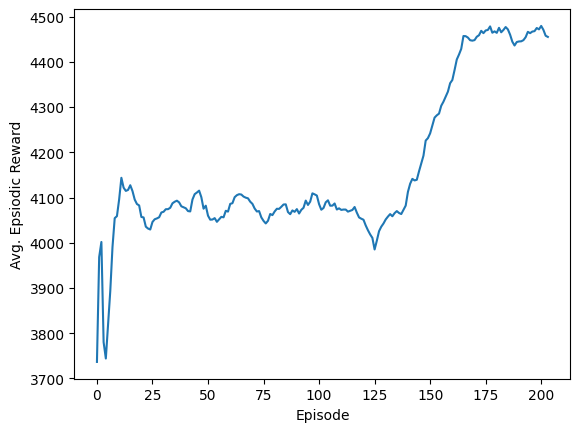

In [15]:
plt.plot(avg_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Epsiodic Reward")
plt.show()

In [ ]:
############################ Predict ############################
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
import matplotlib.pyplot as plt
import math
from tensorflow.keras.models import load_model
from matplotlib import animation
from env_predict import *
from buffer import *
from model import *
from noise import *

dt = 0.4
v = 1.0
ve = 1.2
#Dimension of State Space for single agent
dim_agent_state = 5
num_agents = 3
#Dimension of State Space
dim_state = dim_agent_state*num_agents
#Number of Episodes
num_episodes = 3000
#Number of Steps
num_steps = 400
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))
ac_models = []
cr_models = []
target_ac = []
target_cr = []
path = '/content/drive/My Drive/Ph. D. Coursework/ECEN743_ReinforcementLearning/ECEN743_Project/Models/'

for i in range(num_agents):
    ac_models.append(load_model(path + 'actor'+str(i)+'.h5')) 
    cr_models.append(load_model(path + 'critic'+str(i)+'.h5'))
    target_ac.append(load_model(path + 'target_actor'+str(i)+'.h5'))
    target_cr.append(load_model(path + 'target_critic'+str(i)+'.h5'))

def policy(state, noise_object, model):
    sampled_actions = tf.squeeze(model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + 0
    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, -1.0, 1.0)
    return [np.squeeze(legal_action)]

ep_reward_list = []
# To store average reward history of last few episodes
avg_reward_list = []
ag1_reward_list = []
ag2_reward_list = []
ev_reward_list = []

# Takes about 20 min to train
for ep in range(1):
    env = environment()
    prev_state = env.initial_obs()
    episodic_reward = 0
    ag1_reward = 0
    ag2_reward = 0
    ev_reward = 0
    xp1 = []
    yp1 = []
    xp2 = []
    yp2 = []
    xce = []
    yce = []

    #while True:
    for i in range(400):
        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        actions = []
        for j, model in enumerate(ac_models):
            action = policy(tf_prev_state[:,5*j:5*(j+1)], ou_noise, model)
            actions.append(float(action[0]))
        # Recieve state and reward from environment.
        #new_state, sys_state, ev_state = transition(prev_state, sys_state, actions, ev_state)
        new_state = env.step(actions)
        rewards = reward(new_state)
        #buffer.record((prev_state, actions, rewards, new_state))
        episodic_reward += sum(rewards)
        ag1_reward += rewards[0]
        ag2_reward += rewards[1]
        ev_reward += rewards[2]

        '''buffer.learn(ac_models, cr_models, target_ac, target_cr)
        update_target(tau, ac_models, cr_models, target_ac, target_cr)'''

        prev_state = new_state
        xp1.append(env.p1_rx)
        yp1.append(env.p1_ry)
        xp2.append(env.p2_rx)
        yp2.append(env.p2_ry)
        xce.append(env.e_rx)
        yce.append(env.e_ry)
        d_p1_e = L(env.p1_rx, env.p1_ry, env.e_rx, env.e_ry)
        d_p2_e = L(env.p2_rx, env.p2_ry, env.e_rx, env.e_ry)

        if d_p1_e < 0.4 or d_p2_e < 0.4:
            env = environment()
            prev_state = env.initial_obs()
            print("Captured")
            #break

    xc1 = [env.e_rx]
    yc1 = [env.e_ry]
    ep_reward_list.append(episodic_reward)
    ag1_reward_list.append(ag1_reward)
    ag2_reward_list.append(ag2_reward)
    ev_reward_list.append(ev_reward)
    # Mean of last 40 episodes
    avg_reward = np.mean(ep_reward_list[-40:])
    print("Trajectory plot will be generated")
    avg_reward_list.append(avg_reward)
    plt.plot(xp1,yp1)
    plt.plot(xp2,yp2)
    plt.plot(xce,yce)
    plt.plot(xc1,yc1,'.') 
    plt.plot(xp1[-1],yp1[-1],'*')
    plt.plot(xp2[-1],yp2[-1],'*')
plt.show()
    
print("Trajectory Animation will be generated")
# Creating animation of the complete episode during execution
# First set up the figure, the axis, and the plot element we want to animate
fig = plt.figure()
ax = plt.axes(xlim=(-1, 11), ylim=(-1, 11))
line, = ax.plot([], [], 'go')
line1, = ax.plot([], [], 'go')
line2, = ax.plot([], [], 'ro')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    line1.set_data([], [])
    line2.set_data([], [])
    return line, line1, line2,

# animation function.  This is called sequentially
def animate(i):
    x = xp1[i-1:i]
    y = yp1[i-1:i]
    x2 = xp2[i-1:i]
    y2 = yp2[i-1:i]
    x_ = xce[i-1:i]
    y_ = yce[i-1:i]
    line.set_data(x, y)
    line1.set_data(x2, y2)
    line2.set_data(x_, y_)
    return line, line1, line2,

# call the animator.  blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=600, interval=1, blit=True)

# save the animation as an mp4. This requires ffmpeg or mencoder to be
# installed.  The extra_args ensure that the x264 codec is used, so that
# the video can be embedded in html5.  You may need to adjust this for
# your system: for more information, see
# http://matplotlib.sourceforge.net/api/animation_api.html
anim.save('basic_animation.mp4', fps=20, extra_args=['-vcodec', 'libx264'])
# Plotting graph
# Episodes versus Avg. Rewards
plt.show()